# Notebook to spot check classifiers and parameterize top 2 to choose best

In [1]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import pylab as plot
import matplotlib.gridspec as gridspec
from matplotlib import rcParams
import seaborn as sns

import numpy as np
import pickle

import pandas as pd
pd.set_option('mode.chained_assignment', None)

from gensim.models.fasttext import FastText as FT_gensim
import gensim
from gensim import corpora, models
from gensim.models.phrases import Phrases, Phraser
from gensim import models

from sklearn.model_selection import train_test_split,cross_validate, cross_val_score,StratifiedKFold,KFold
from sklearn.metrics import fbeta_score,f1_score,hamming_loss,accuracy_score, confusion_matrix,f1_score,precision_score,log_loss,classification_report,mean_squared_error,make_scorer,roc_curve,auc,precision_recall_curve
from scipy.stats import entropy
from sklearn.metrics import multilabel_confusion_matrix
import logging
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier,VotingClassifier
from sklearn.svm import LinearSVC,SVC
import xgboost as xgb
from sklearn.neural_network import MLPClassifier
from sklearn.multiclass import OneVsRestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV


from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
import warnings
warnings.filterwarnings('ignore')

# figure size in inches
rcParams['figure.figsize'] = 11.7,8.27


params = {'legend.fontsize': 20,
          'legend.handlelength': 2}
plot.rcParams.update(params)
Path_model='../data/Metacyc/models/'
Path='../data/Metacyc/'

/Users/saijananiganesan/anaconda3/lib/python3.6/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


## All required functions

In [2]:
fname='df_metacyc_3ormore_multilabel2.pkl'
data_df_multi=pickle.load(open(Path+fname,'rb'))
non_model=FT_gensim.load(Path_model+'model_300_FT_3.model')
#n300_model=FT_gensim.load(Path_model+'model_300_FT.model')
#n300w_model=FT_gensim.load(Path_model+'model_300_w100_FT.model')
global all_enzymes
all_enzymes=set([j for i in data_df_multi.EC for j in i])
data_df_multi2=data_df_multi.copy()
global categories
categories=[
       'Biosynthesis', 'Degradation', 'Energy', 'Glycan',
       'Macromolecule']
data_df_multi=data_df_multi[data_df_multi['Bioluminescence']==0]
data_df_multi=data_df_multi[data_df_multi['Detoxification']==0]
data_df_multi=data_df_multi[data_df_multi['Activation']==0]
#data_df_multi=data_df_multi[data_df_multi['Super-Pathways']==0]
#data_df_multi=data_df_multi[data_df_multi['Metabolic-Clusters']==0]


In [3]:
data_df_multi[data_df_multi['Map']=='PWY-5410']['EC_set'].to_list()


[['ec:2.3.1.195',
  'ec:1.13.11.12',
  'ec:4.2.1.m17',
  'ec:4.2.1.m19',
  'ec:1.1.1.2']]

In [4]:
def get_train_and_test(df):
    train,test=train_test_split(df,test_size=0.10)
    EC_list_train=get_EC_list(train)
    EC_list_test=get_EC_list(test)
    EC_list_data=get_EC_list(df)
    return EC_list_data,EC_list_train,EC_list_test,train,test

def get_train_and_valid(df):
    train,valid=train_test_split(df,test_size=0.33)
    return train,valid

def get_EC_list(df):
    EC_list_init=df['EC'].values.tolist()
    EC_list=[list((i)) for i in EC_list_init]
    return EC_list

def get_all_classes(df):
    classes=sorted(list(set(df['Label Name'].to_list())))
    return classes

def partial_annotation3(pathway):
    return ['.'.join(i.split('.')[:-1]) for i in pathway]

def partial_annotation2(pathway):
    return ['.'.join(i.split('.')[:-2]) for i in pathway]

def partial_annotation1(pathway):
    return ['.'.join(i.split('.')[:-3]) for i in pathway]

def label_enzymes(ec_set,all_enzymes=all_enzymes):
    lst=[]
    for i in all_enzymes:
        if i in ec_set:
            lst.append(1)
        else:
            lst.append(0)
    return np.array(lst)

def pathway_vector(pathway,model_gensim):
    #print (pathway)
    """Create document vectors by averaging word vectors. Remove out-of-vocabulary words."""
    #combined=model_gensim[pathway]
    #return np.asarray(combined).reshape(-1)
    return np.mean(model_gensim[pathway],axis=0)
 
def get_X_and_Y(data_df_multi,categories):
    data_df_multi['pathway_vector'] = data_df_multi.EC_set.apply(pathway_vector,model_gensim=non_model)
    data_df,valid_df=get_train_and_valid(data_df_multi.copy())
    X_train=list(data_df.pathway_vector)
    X_test=list(valid_df.pathway_vector)
    Y_train=data_df[categories]
    Y_test=valid_df[categories]
    return X_train,Y_train,X_test,Y_test

def get_X_and_Y_train(data_df_multi,categories):
    data_df_multi['pathway_vector'] = data_df_multi.EC_set.apply(pathway_vector,model_gensim=non_model)
    X_train=list(data_df_multi.pathway_vector)
    Y_train=data_df_multi[categories]
    return X_train,Y_train

def get_X_and_Y_control(data_df_multi,categories):
    data_df_multi['control_label']=data_df_multi.EC_set.apply(label_enzymes)
    data_df,valid_df=get_train_and_valid(data_df_multi.copy())
    X_train=list(data_df.control_label)
    X_test=list(valid_df.control_label)
    Y_train=data_df[categories]
    Y_test=valid_df[categories]
    return X_train,Y_train,X_test,Y_test

def get_X_and_Y_annot3(data_df_multi,categories):
    data_df_multi['anot'] = data_df_multi.EC_set.apply(partial_annotation3)
    data_df_multi['pathway_vector'] = data_df_multi.anot.apply(pathway_vector,model_gensim=non_model)
    X_annot3=list(data_df_multi.pathway_vector)
    Y_annot3=data_df_multi[categories]
    return X_annot3,Y_annot3

def get_X_and_Y_annot2(data_df_multi,categories):
    data_df_multi['anot'] = data_df_multi.EC_set.apply(partial_annotation2)
    data_df_multi['pathway_vector'] = data_df_multi.anot.apply(pathway_vector,model_gensim=non_model)
    X_annot3=list(data_df_multi.pathway_vector)
    Y_annot3=data_df_multi[categories]
    return X_annot3,Y_annot3

def get_X_and_Y_annot1(data_df_multi,categories):
    data_df_multi['anot'] = data_df_multi.EC.apply(partial_annotation1)
    data_df_multi['pathway_vector'] = data_df_multi.anot.apply(pathway_vector,model_gensim=non_model)
    X_annot3=list(data_df_multi.pathway_vector)
    Y_annot3=data_df_multi[categories]
    return X_annot3,Y_annot3

# Spot Check Algorithms
def spot_check(X_train,Y_train):
    models = []
    models.append(('SVC', OneVsRestClassifier(SVC(probability=True))))
    models.append(('RM', OneVsRestClassifier(RandomForestClassifier(criterion='entropy'))))
    models.append(('GB',OneVsRestClassifier(GradientBoostingClassifier())))
    models.append(('MLP',OneVsRestClassifier(MLPClassifier())))
    models.append(('LR',OneVsRestClassifier(LogisticRegression())))
    models.append(('VR',VotingClassifier(estimators=[
                        ('SVC', OneVsRestClassifier(SVC(probability=True))),
                        ('RM', OneVsRestClassifier(RandomForestClassifier(criterion='entropy')))],
                        voting='soft')))

    acc = [];loss=[]
    names = []
    scoring = {'hamming':make_scorer(hamming_loss),
           'Accuracy': make_scorer(accuracy_score)}
    for i,tup in enumerate(models):
        name=tup[0]
        model=tup[1]
        kfold=KFold(n_splits=10, random_state=1, shuffle=True)
        cv_results=cross_validate(model, X_train, Y_train, cv=kfold, scoring=scoring,return_train_score=True)
        acc.append(cv_results['test_Accuracy'])
        loss.append(cv_results['test_hamming'])
        names.append(name)
    #print('%s: %f (%f)' % (names, cv_results))
    return names,acc,loss
    
def strplot(df,title):
    fig = plt.figure(figsize=(10,7))
    ax = fig.add_subplot(111)
    ax=sns.boxplot(data=df)
    ax=sns.stripplot(data=df, 
              size=8, jitter=True, edgecolor="gray", linewidth=2)
    #ax.set_ylim([0,1])
    ax.set_ylabel(title,fontsize=20)
    ax.set_xticklabels(df.columns)
    ax.tick_params(labelsize=16)
    #ax.set_title(title,fontsize=16)
    
def roc_curve_plot(categories,test_array,prediction_prob):
    fig = plt.figure(figsize=(10,7))
    ax1 = fig.add_subplot(111)
    fpr = dict();tpr = dict();roc_auc = dict()
    for i in range(len(categories)):
        fpr[i], tpr[i], _ = roc_curve(test_array[:, i], prediction_prob[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])
    for i in range(len(categories)):
        plt.plot(fpr[i], tpr[i],'--', label='ROC curve %s (area = %0.2f)' % (categories[i],roc_auc[i]),lw=4)
        plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate',fontsize=18)
    plt.ylabel('True Positive Rate',fontsize=18)
    plt.title('Receiver operating characteristics',fontsize=18)
    plt.legend(bbox_to_anchor=(1.1, 1.05))
    ax1.tick_params(axis='both', which='major', labelsize=16)

    
def pr_curve(categories,test_array,prediction_prob):
    fig = plt.figure(figsize=(10,7))
    ax1 = fig.add_subplot(111)
    precision=dict();recall=dict()
    for i in range(len(categories)):
        precision[i], recall[i], _ = precision_recall_curve(test_array[:, i], prediction_prob[:, i])
    for i in range(len(categories)):
        plt.plot(precision[i], recall[i],'--', label='Precision-recall curve %s ' % categories[i],lw=4)
        plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('Recall',fontsize=18)
    plt.ylabel('Precision',fontsize=18)
    plt.title('Precision vs Recall',fontsize=18)
    plt.legend(bbox_to_anchor=(1.1, 1.05))
    ax1.tick_params(axis='both', which='major', labelsize=16)
    
def evaluate(Tp,Tn,Fp,Fn):
    recall=Tp/(Tp+Fn)
    precision=Tp/(Tp+Fp)
    f1=2*(precision*recall)/(precision+recall)
    print('Recall = {:0.2f}%.'.format(recall))
    print('F1 score = {:0.2f}%.'.format(f1))
    print('Precision score = {:0.2f}%.'.format(precision))
    return recall,precision,f1

def multi_cm(Y_test,Y_pred):
    all_mats=multilabel_confusion_matrix(Y_test,Y_pred);
    count=0;
    for conf_mat in all_mats:
        fig, ax = plt.subplots(figsize=(5,5));
        sns.heatmap(conf_mat,annot=True, fmt='d',cmap="Blues",linewidths=.5,cbar=False,annot_kws={"size": 14});
        plt.ylabel('Actual',fontsize=16);
        plt.xlabel('Predicted',fontsize=16);
        ax.set_xticklabels([0,1],fontsize=16);
        ax.set_yticklabels([0,1],fontsize=16);
        plt.title(Y_test.columns[count],fontsize=16);
        count=count+1;
    return all_mats

def evaluate_all_labels(all_mats,categories):
    for i in range(all_mats.shape[0]):
        tn=all_mats[i][0,0]
        fp=all_mats[i][0,1]
        fn=all_mats[i][1,0]
        tp=all_mats[i][1,1]
        print('Model Performance %s' %categories[i])
        evaluate(tp,tn,fp,fn)
    
def evaluate_ml_metrics(Y_test,Y_pred):
    acc=[];prec=[];recall=[];f1=[]
    for i,j in enumerate(Y_test.to_numpy()):
        inter=[a for b,a in enumerate(j) if (a==Y_pred[i][b]) and (a==1)]
        union_1=[a for b,a in enumerate(j) if a!=Y_pred[i][b] and (a==1)]
        union_2=[a for b,a in enumerate(j) if a!=Y_pred[i][b] and (Y_pred[i][b]==1)]
        union_f=len(inter)+len(union_1)+len(union_2)
        if union_f>0:
            acc.append(len(inter)/union_f)
        if ((len(union_1)+len(inter)))>0:
            recall.append(len(inter)/(len(union_1)+len(inter)))
        if ((len(union_2)+len(inter)))>0:
            prec.append(len(inter)/(len(union_2)+len(inter)))
        if (len(union_1)+len(union_2))>0:
            f1.append(2*len(inter)/(len(union_1)+len(union_2)))
    return sum(acc)/len(acc),sum(recall)/len(acc),sum(prec)/len(acc),sum(f1)/len(acc)

def VR(X_train,Y_train):
    models = []
    models.append(('VR',VotingClassifier(estimators=[
                        ('SVC', OneVsRestClassifier(SVC(probability=True))),
                        ('RM', OneVsRestClassifier(RandomForestClassifier(criterion='entropy')))],
                        voting='soft')))

    acc = [];loss=[]
    names = []
    scoring = {'hamming':make_scorer(hamming_loss),
           'Accuracy': make_scorer(accuracy_score)}
    for i,tup in enumerate(models):
        name=tup[0]
        model=tup[1]
        model.fit(X_train,Y_train)
        #kfold=KFold(n_splits=10, random_state=1, shuffle=True)
        #cv_results=cross_validate(model, X_train, Y_train, cv=kfold, scoring=scoring,return_train_score=True)
        #print (cv_results)
        #acc.append(cv_results['test_Accuracy'])
        #loss.append(cv_results['test_hamming'])
        #names.append(name)
    #print('%s: %f (%f)' % (names, cv_results))
    return names,acc,loss


## Spot check 5 classifiers: SVM, RM, GB, MLP, and LR

['SVC', 'RM', 'GB', 'MLP', 'LR', 'VR']
[array([0.81927711, 0.76506024, 0.73493976, 0.73493976, 0.72289157,
       0.77710843, 0.77710843, 0.75757576, 0.77575758, 0.78181818]), array([0.77710843, 0.71686747, 0.74096386, 0.77710843, 0.68674699,
       0.77710843, 0.71686747, 0.75151515, 0.72727273, 0.73333333]), array([0.76506024, 0.74096386, 0.69879518, 0.70481928, 0.72289157,
       0.71084337, 0.69277108, 0.72727273, 0.72727273, 0.72727273]), array([0.75301205, 0.75301205, 0.70481928, 0.78313253, 0.6746988 ,
       0.72891566, 0.69879518, 0.75151515, 0.72727273, 0.7030303 ]), array([0.75301205, 0.68674699, 0.63855422, 0.72289157, 0.65662651,
       0.74096386, 0.69879518, 0.70909091, 0.72727273, 0.64848485]), array([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan])]


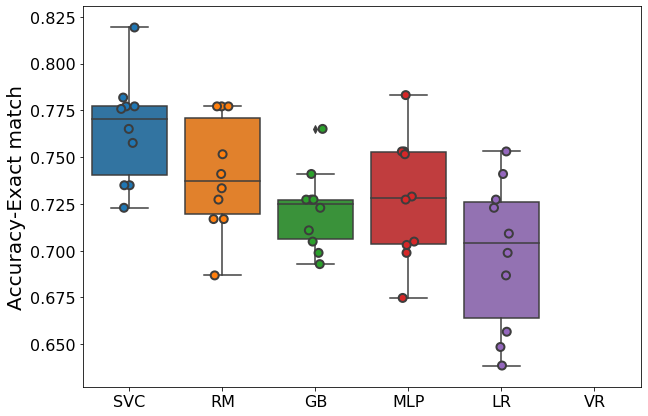

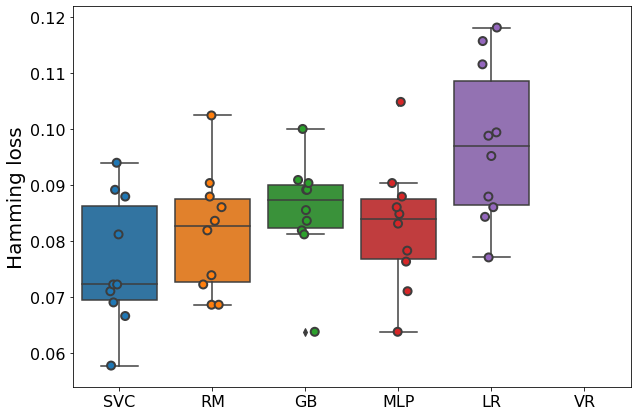

In [5]:
X_train,Y_train,X_test,Y_test=get_X_and_Y(data_df_multi,categories)
names,acc,loss=spot_check(X_train,Y_train)
print (names)
print (acc)
df_acc=pd.DataFrame(acc).T
df_acc.rename(columns={0:names[0],1:names[1],2:names[2],3:names[3],4:names[4],5:names[5]},inplace=True)
df_loss=pd.DataFrame(loss).T
df_loss.rename(columns={0:names[0],1:names[1],2:names[2],3:names[3],4:names[4],5:names[5]},inplace=True)
strplot(df_acc,title='Accuracy-Exact match')
strplot(df_loss,title='Hamming loss')

In [6]:
df_acc.describe()

,SVC,RM,GB,MLP,LR,VR
count,10.000000,10.000000,10.000000,10.000000,10.000000,0.0
mean,0.764648,0.740489,0.721796,0.727820,0.698244,NaN
std,0.028425,0.030505,0.021370,0.032829,0.039855,NaN
min,0.722892,0.686747,0.692771,0.674699,0.638554,NaN
25%,0.740599,0.719469,0.706325,0.703478,0.664157,NaN
50%,0.770409,0.737149,0.725082,0.728094,0.703943,NaN
75%,0.777108,0.770710,0.727273,0.752638,0.726177,NaN
max,0.819277,0.777108,0.765060,0.783133,0.753012,NaN


In [7]:
df_loss.describe()

,SVC,RM,GB,MLP,LR,VR
count,10.000000,10.000000,10.000000,10.000000,10.000000,0.0
mean,0.076155,0.081593,0.085576,0.082679,0.097408,NaN
std,0.011463,0.010821,0.009386,0.011260,0.014028,NaN
min,0.057831,0.068675,0.063855,0.063855,0.077108,NaN
25%,0.069589,0.072702,0.082355,0.076851,0.086533,NaN
50%,0.072289,0.082782,0.087349,0.083991,0.096988,NaN
75%,0.086267,0.087479,0.090060,0.087479,0.108485,NaN
max,0.093976,0.102410,0.100000,0.104819,0.118072,NaN


## Top 2 classifiers are SVC/SVM and RM

### Explore individual label accuracy, ROC, AUC scores, precision, recall, confusion matrix etc

In [8]:
models = []
models.append(('SVC', OneVsRestClassifier(SVC(probability=True))))
models.append(('RM', OneVsRestClassifier(RandomForestClassifier(criterion='entropy'))))

### Exploring SVC classifier in detail

#### AUC and ROC curves

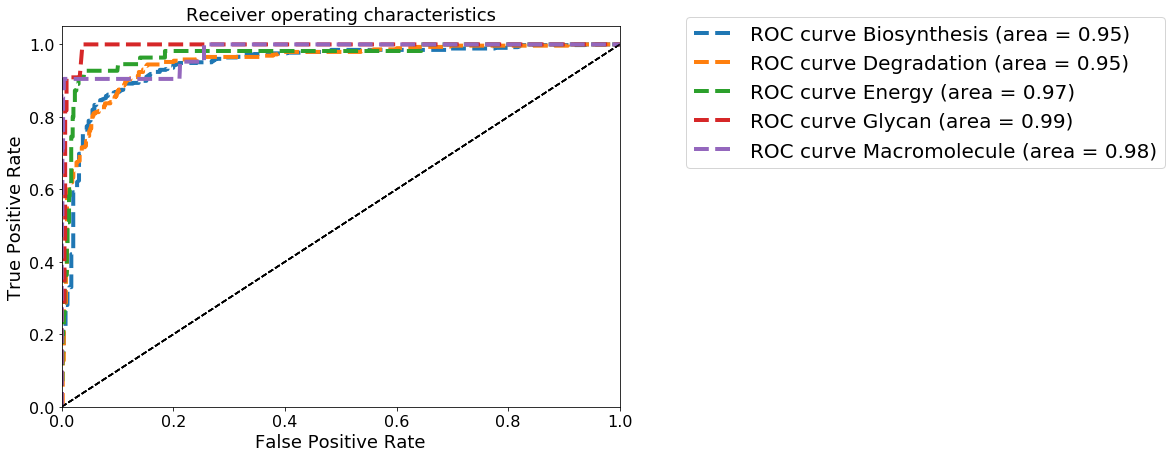

In [9]:
X_train,Y_train=get_X_and_Y_train(data_df_multi,categories)

model=models[0][1].fit(X_train, Y_train)
prediction=model.predict(X_test)
prediction_prob=model.predict_proba(X_test)
Y_pred=model.predict(X_test)
test_array = Y_test.to_numpy()
roc_curve_plot(categories,test_array,prediction_prob)


#### Confusion matrix and recall, F1, and precision

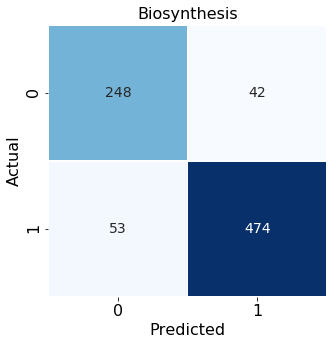

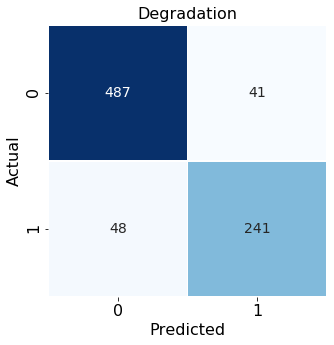

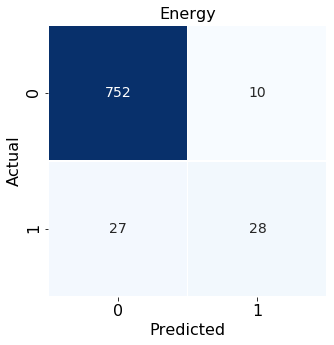

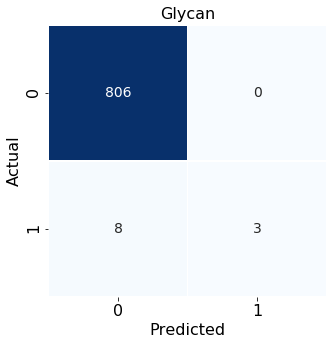

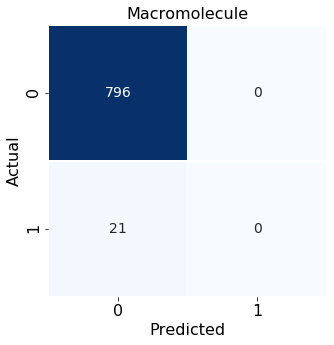

In [10]:
all_mats=multi_cm(Y_test,Y_pred)

### Exploring RM classifier in detail

#### AUC and ROC curves

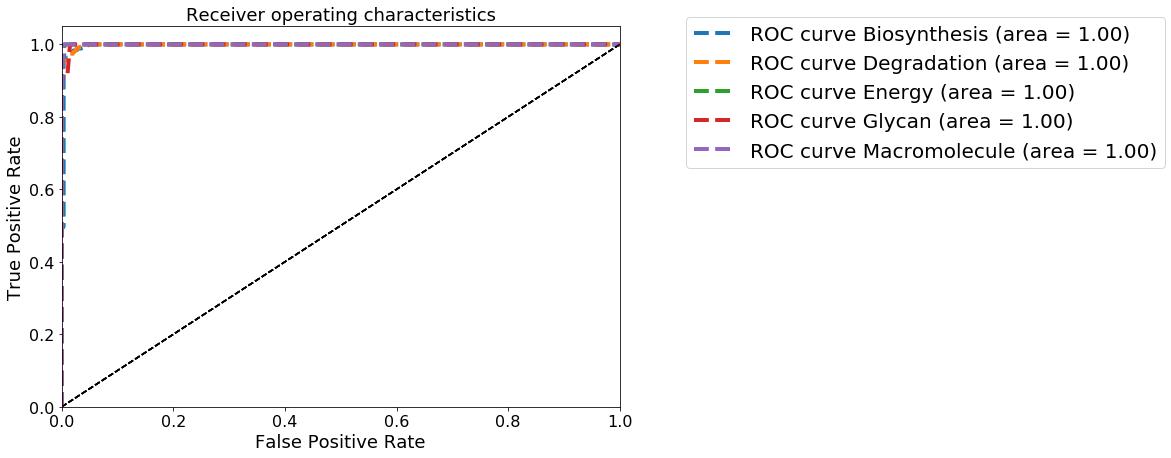

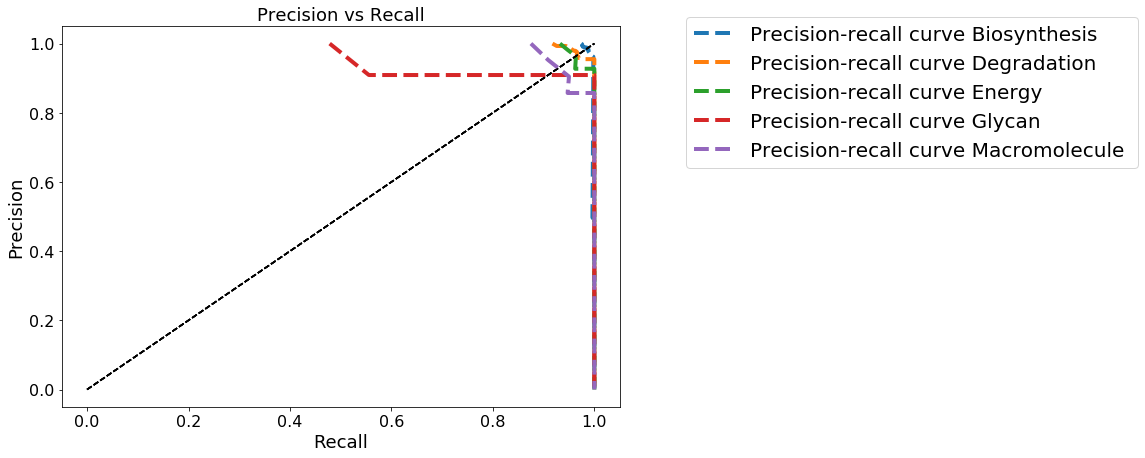

In [11]:
X_train,Y_train=get_X_and_Y_train(data_df_multi,categories)
model=models[1][1].fit(X_train, Y_train)
prediction=model.predict(X_test)
prediction_prob=model.predict_proba(X_test)
Y_pred = model.predict(X_test)
test_array = Y_test.to_numpy()
roc_curve_plot(categories,test_array,prediction_prob)
pr_curve(categories,test_array,prediction_prob)
filename = 'Rm_model.sav'
pickle.dump(model, open(filename, 'wb'))



In [12]:
model.get_params()

{'estimator__bootstrap': True,
 'estimator__ccp_alpha': 0.0,
 'estimator__class_weight': None,
 'estimator__criterion': 'entropy',
 'estimator__max_depth': None,
 'estimator__max_features': 'auto',
 'estimator__max_leaf_nodes': None,
 'estimator__max_samples': None,
 'estimator__min_impurity_decrease': 0.0,
 'estimator__min_impurity_split': None,
 'estimator__min_samples_leaf': 1,
 'estimator__min_samples_split': 2,
 'estimator__min_weight_fraction_leaf': 0.0,
 'estimator__n_estimators': 100,
 'estimator__n_jobs': None,
 'estimator__oob_score': False,
 'estimator__random_state': None,
 'estimator__verbose': 0,
 'estimator__warm_start': False,
 'estimator': RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                        criterion='entropy', max_depth=None, max_features='auto',
                        max_leaf_nodes=None, max_samples=None,
                        min_impurity_decrease=0.0, min_impurity_split=None,
                        min_samples_leaf=

#### Confusion matrix, precision, recall, and F1

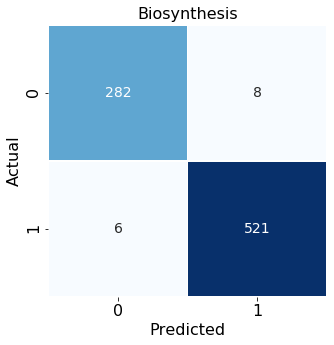

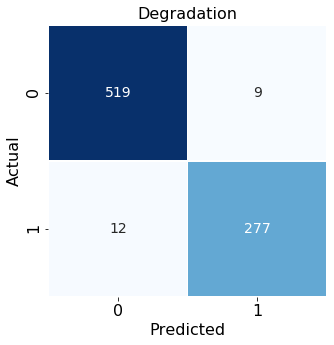

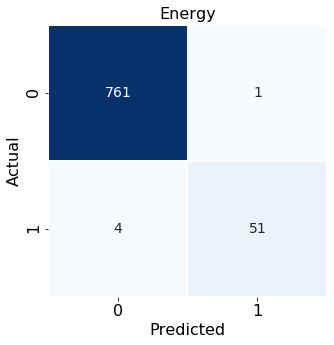

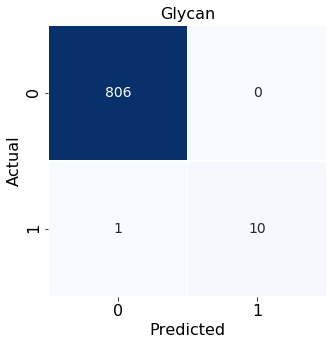

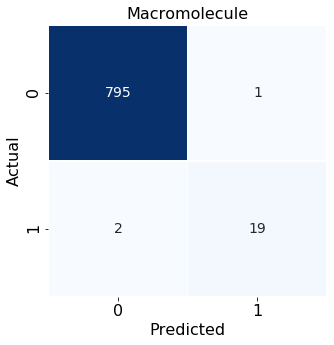

In [13]:
all_mats=multi_cm(Y_test,Y_pred)

## Paramterize RM classifier
### 1. Randomized search CV
### 2. Grid search CV

In [14]:
def grid_search_rf():
    param_grid_rm ={
    'estimator__n_estimators':[1500,1800,2000] ,
     'estimator__min_samples_split': [6,8,10,12,14],
     'estimator__min_samples_leaf': [2, 4,6,8],
     'estimator__max_features': ['sqrt','auto'],
     'estimator__max_depth': [200,400,600,800,1000],
     'estimator__criterion': ['gini'] }

    scoring = {'hamming':make_scorer(hamming_loss),
           'Accuracy': make_scorer(accuracy_score)}

# Create a based model
    rf = OneVsRestClassifier(RandomForestClassifier())
# Instantiate the grid search model
    grid_search = GridSearchCV(estimator = rf, param_grid = param_grid_rm, cv = 3, n_jobs = -1, verbose = 2,scoring=make_scorer(accuracy_score))
    grid_search.fit(X_train,Y_train)
    grid_search.best_params_
    return grid_search


In [15]:
def fit_best_param_rf(grid_search,X_train, Y_train, X_test, Y_test):
    best_rf=grid_search.best_estimator_
    model=best_rf.fit(X_train, Y_train)
    prediction=model.predict(X_test)
    prediction_prob=model.predict_proba(X_test)
    Y_pred = model.predict(X_test)
    test_array = Y_test.to_numpy()
    roc_curve_plot(categories,test_array,prediction_prob)
    pr_curve(categories,test_array,prediction_prob)
    all_mats=multi_cm(Y_test,Y_pred)

In [16]:
def grid_search_svc():
    param_grid_svc ={
    "estimator__C": [1,2,4,8,10,12],
    "estimator__kernel": ["poly","rbf","linear","sigmoid"],
    "estimator__degree":[1, 2, 3, 4],
    "estimator__gamma":['scale', 'auto'],
    "estimator__class_weight":['balanced'],
    }
    svc= OneVsRestClassifier(SVC(probability=True))
    grid_search_svc = GridSearchCV(estimator = svc, param_grid = param_grid_svc, cv = 5, n_jobs = -1, verbose = 2)
    grid_search_svc.fit(X_train,Y_train)
    grid_search_svc.best_params_
    return grid_search_svc


In [17]:
def fit_best_param_svc(grid_search_svc,X_train,Y_train,X_test,Y_test):
    best_svc=grid_search_svc.best_estimator_
    model=best_svc.fit(X_train, Y_train)
    prediction=model.predict(X_test)
    prediction_prob=model.predict_proba(X_test)
    Y_pred = model.predict(X_test)
    test_array = Y_test.to_numpy()
    roc_curve_plot(categories,test_array,prediction_prob)
    pr_curve(categories,test_array,prediction_prob)
    all_mats=multi_cm(Y_test,Y_pred)
    
    
#X_train,Y_train,X_test,Y_test=get_X_and_Y(data_df_multi,categories)
#grid=grid_search_svc()
#fit_best_param_svc(grid,X_train,Y_train,X_test,Y_test)

In [18]:
#print (grid.best_estimator_)

## Model validation

In [19]:
def model_valid(X_train,Y_train,X_test,Y_test,categories):
    models = []
    #models.append(('SVC', OneVsRestClassifier(SVC(probability=True))))
    #models.append(('RM', OneVsRestClassifier(RandomForestClassifier(criterion='entropy'))))
    
  
    models.append(('SVC', OneVsRestClassifier(SVC(probability=True,
                                                  C=8,
                                                  class_weight='balanced',
                                                  degree=1,
                                                  gamma='scale',
                                                  kernel='rbf',
                                                 break_ties=False, cache_size=200,
                                                 coef0=0.0,
                                                 decision_function_shape='ovr',
                                                  max_iter=-1,
                                                 random_state=None,
                                  shrinking=True, tol=0.001, verbose=False))))
   
    models.append(('RM', OneVsRestClassifier(RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                        criterion='entropy', max_depth=None, max_features='auto',
                        max_leaf_nodes=None, max_samples=None,
                        min_impurity_decrease=0.0, min_impurity_split=None,
                        min_samples_leaf=1, min_samples_split=2,
                        min_weight_fraction_leaf=0.0, n_estimators=100,
                        n_jobs=None, oob_score=False, random_state=None,
                        verbose=0, warm_start=False))))
    
    #result = loaded_model.score(X_test, Y_test)

    for i,tup in enumerate(models):
        model=tup[1].fit(X_train, Y_train)
        prediction=model.predict(X_test)
        prediction_prob=model.predict_proba(X_test)
        Y_pred = model.predict(X_test)
        test_array = Y_test.to_numpy()
        roc_curve_plot(categories,test_array,prediction_prob)
        pr_curve(categories,test_array,prediction_prob)
        all_mats=multi_cm(Y_test,Y_pred)
        acc=accuracy_score(Y_test, Y_pred),
        loss=hamming_loss(Y_test, Y_pred)
        acc_c,recall,prec,f1=evaluate_ml_metrics(Y_test,Y_pred)
        print (acc,loss,acc_c,recall,prec,f1) 


### Validation: validation set

In [24]:
from sklearn.base import BaseEstimator,ClassifierMixin
class EnsembleClassifier(BaseEstimator, ClassifierMixin):
    def __init__(self, classifiers=None):
        self.classifiers = classifiers

    def fit(self, X, y):
        for classifier in self.classifiers:
            classifier.fit(X, y)

    def predict_proba(self, X):
        self.predictions_ = list()
        for classifier in self.classifiers:
            self.predictions_.append(classifier.predict_proba(X))
        return np.mean(self.predictions_, axis=0)


(0.7600979192166463,) 0.07906976744186046 0.8043655650754794 0.8289473684210527 0.824765401876785 0.1827825377396981
(0.7307221542227662,) 0.08788249694002448 0.771827825377397 0.7801917584659323 0.8072215422276622 0.16360669114647086


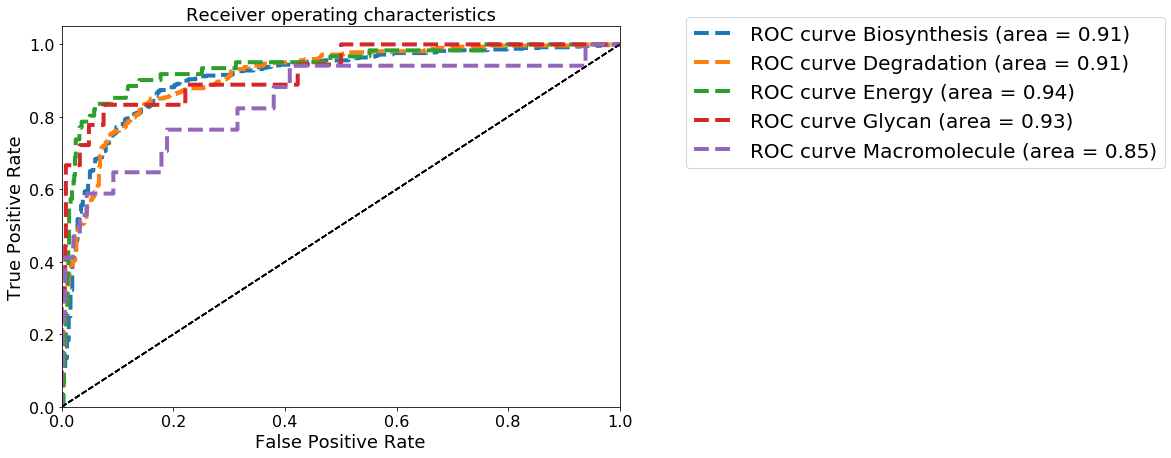

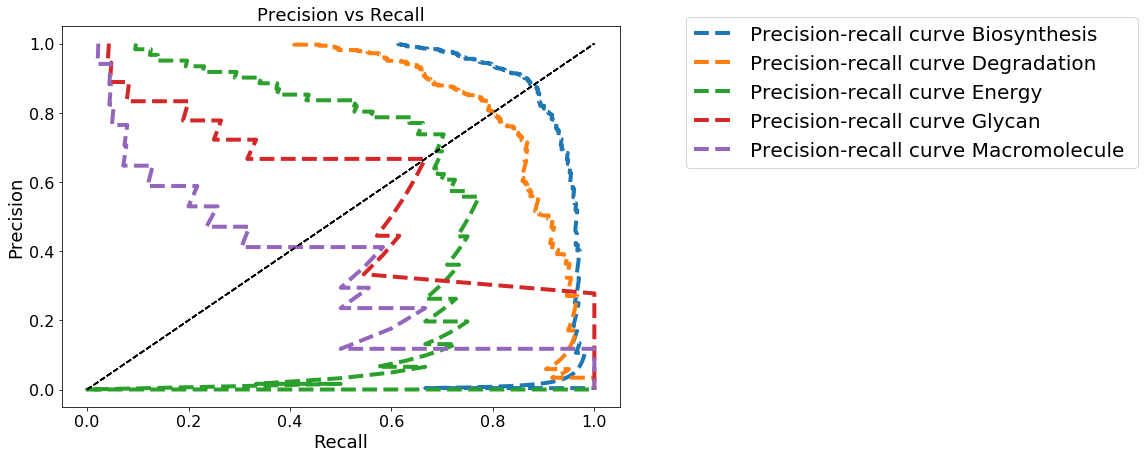

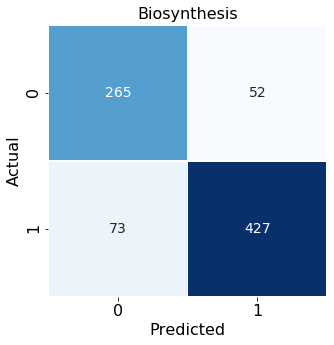

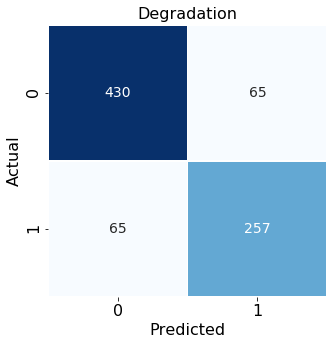

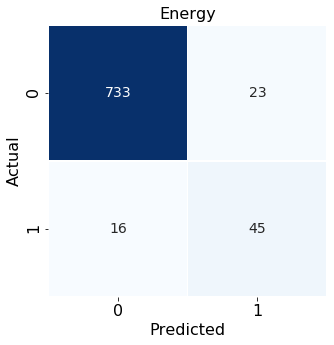

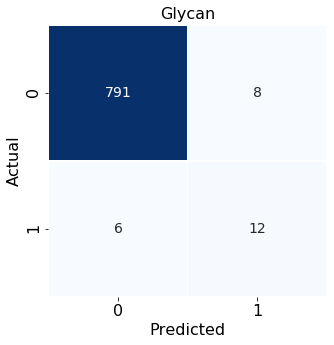

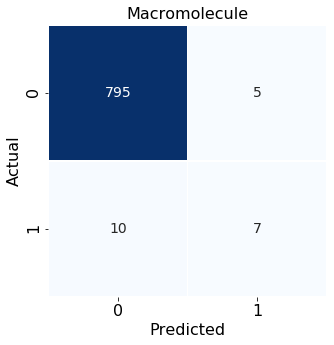

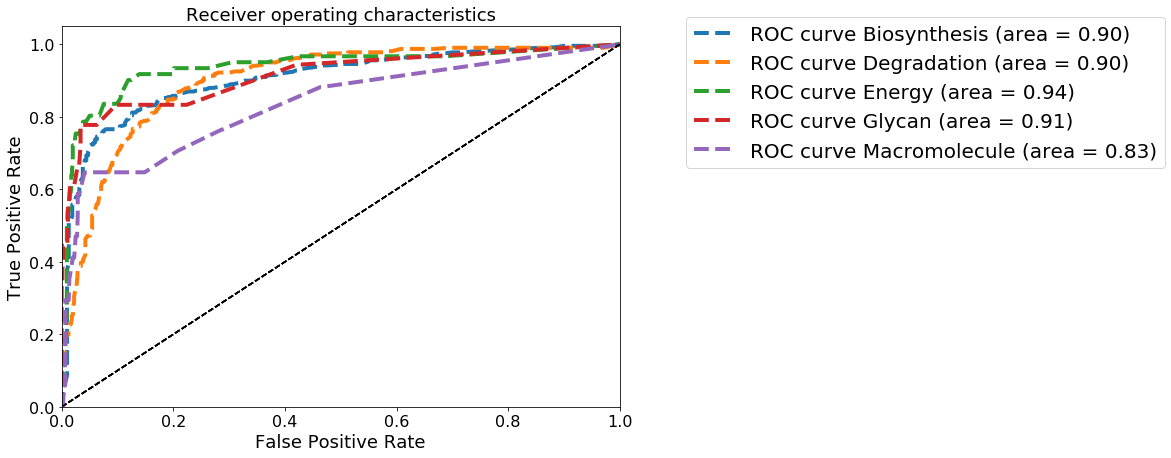

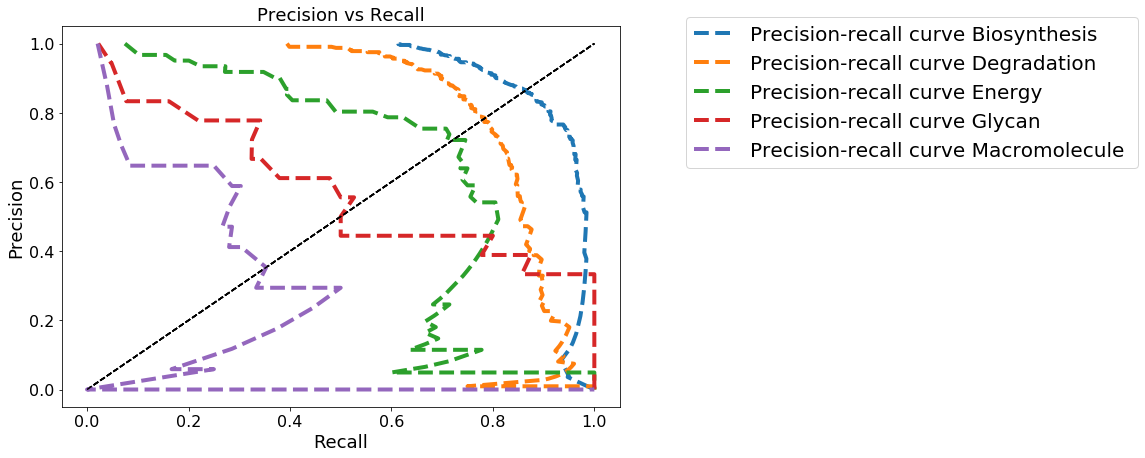

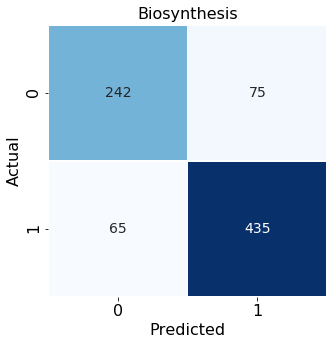

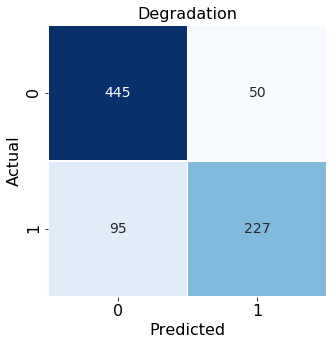

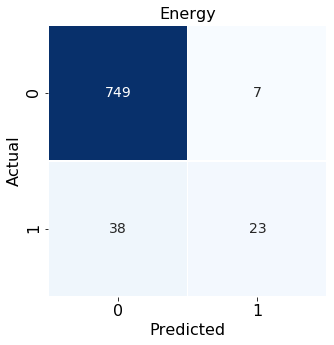

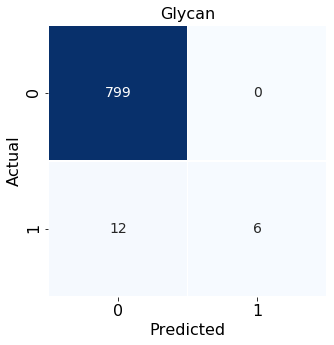

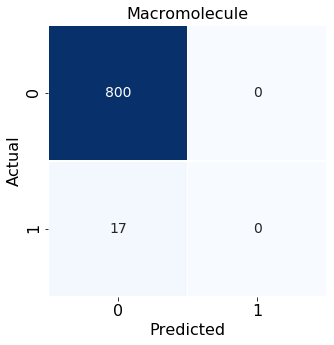

In [22]:
X_train,Y_train,X_test,Y_test=get_X_and_Y(data_df_multi,categories)
model_valid(X_train,Y_train,X_test,Y_test,categories)

### Validation: 3 letter annotation

(0.6475343573160873,) 0.12376717865804365 0.6989355968741577 0.7293856103476153 0.7206952303961196 0.2030450013473457
(0.64874696847211,) 0.12392886014551334 0.6838790083535433 0.691222042576125 0.7140258690379951 0.13810293721368902


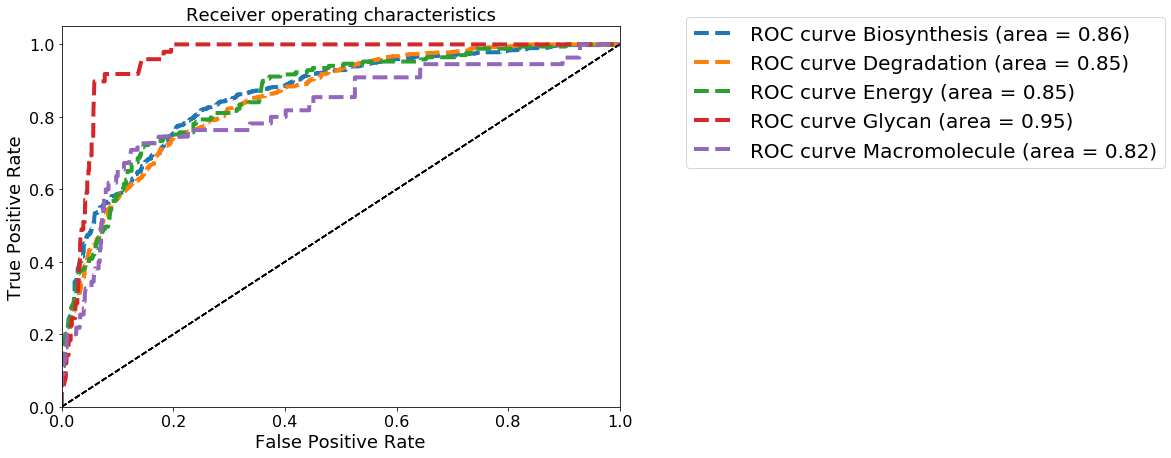

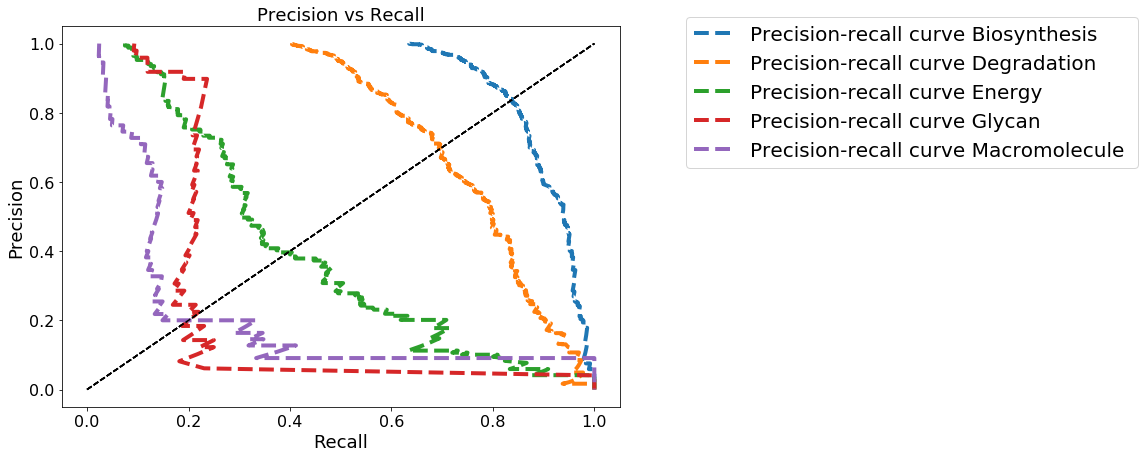

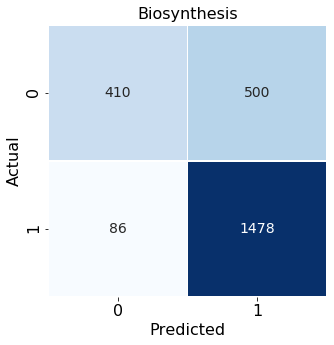

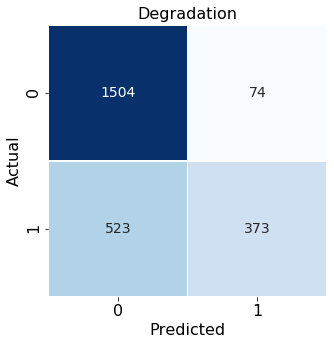

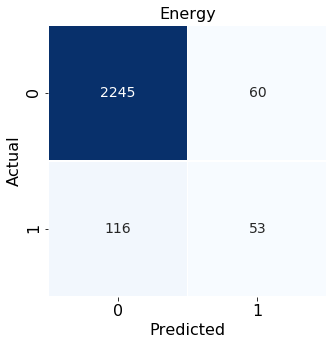

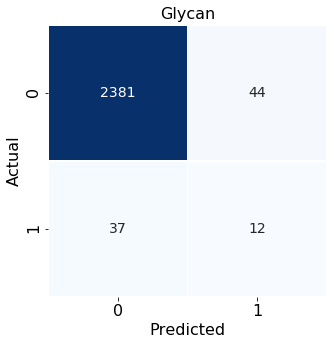

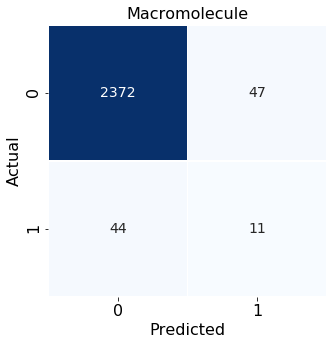

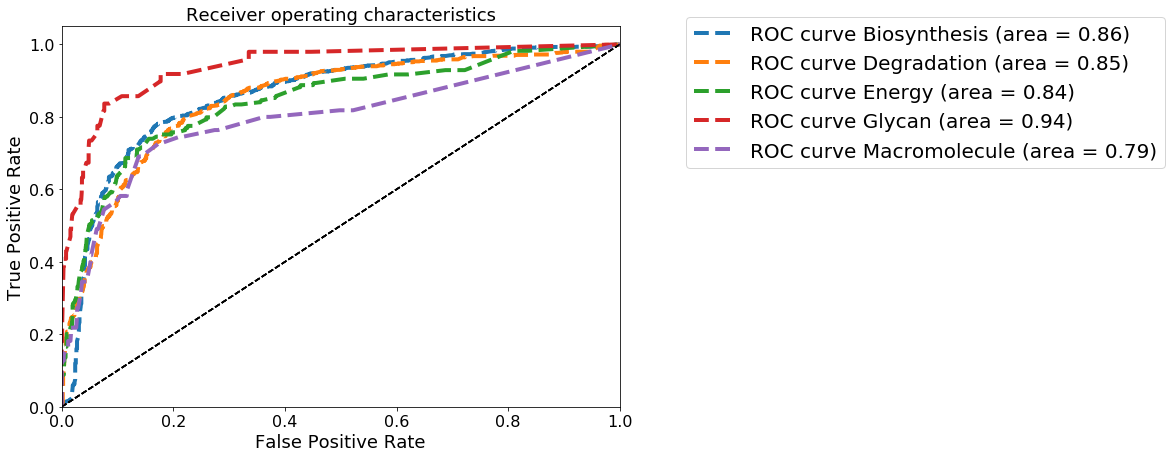

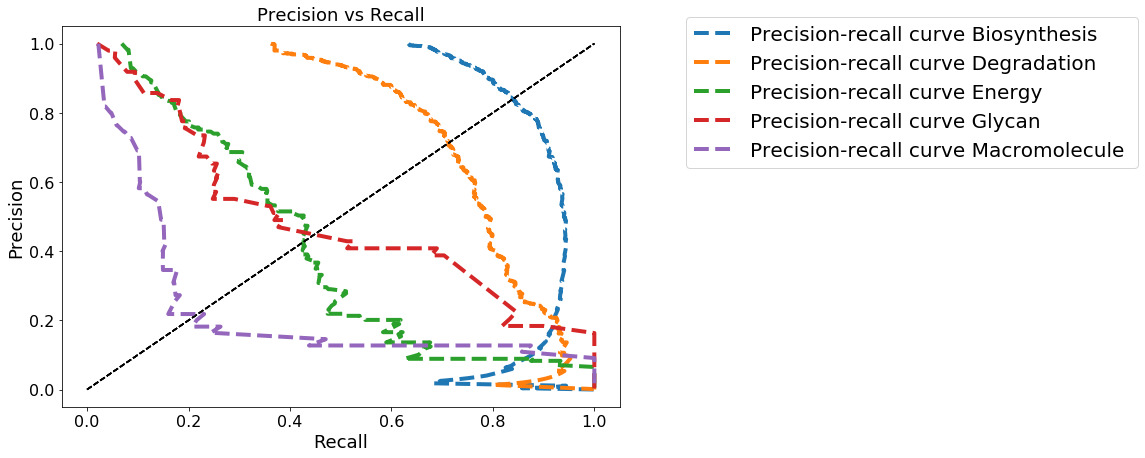

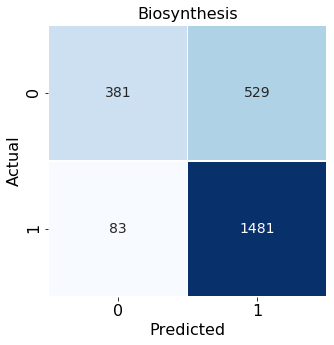

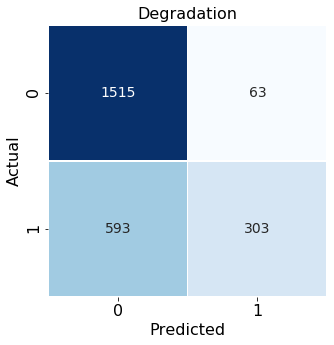

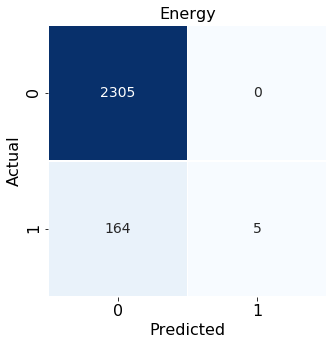

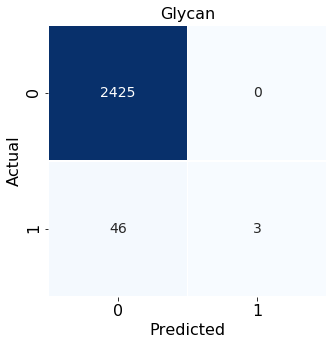

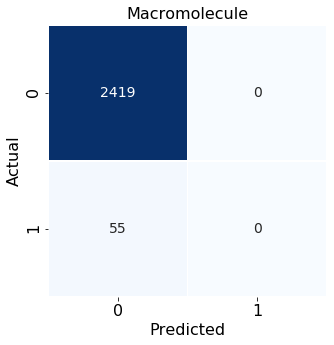

In [25]:
X_train,Y_train=get_X_and_Y_train(data_df_multi,categories)
X_test_c,Y_test_c=get_X_and_Y_annot3(data_df_multi,categories)
model_valid(X_train,Y_train,X_test_c,Y_test_c,categories)

### Validation: 2 letter annotation

(0.5893290218270008,) 0.1614389652384802 0.6236863379143086 0.6379682026407975 0.6458501751549447 0.13433036917272972
(0.6111560226354082,) 0.15408245755860953 0.6342293182430611 0.6369913769873349 0.6566289409862571 0.09040689841013205


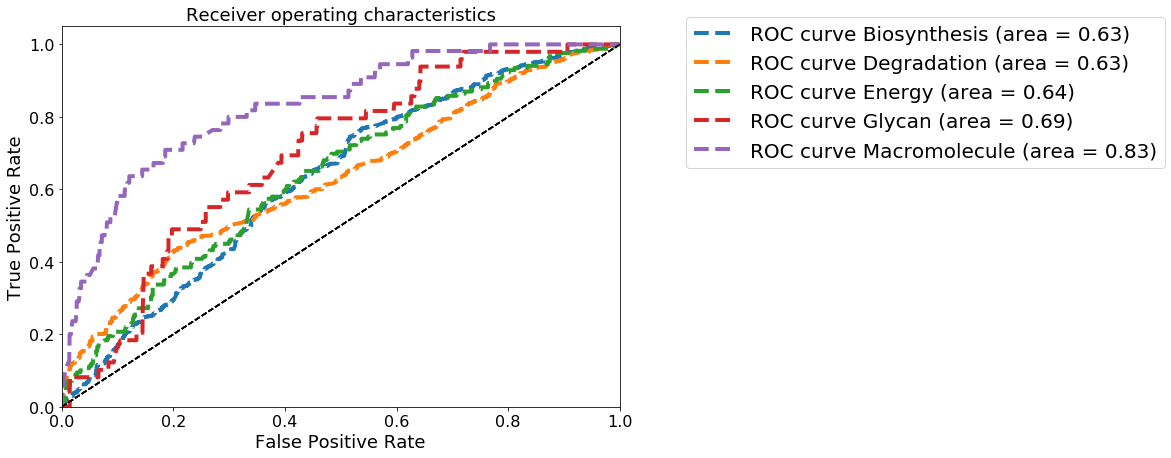

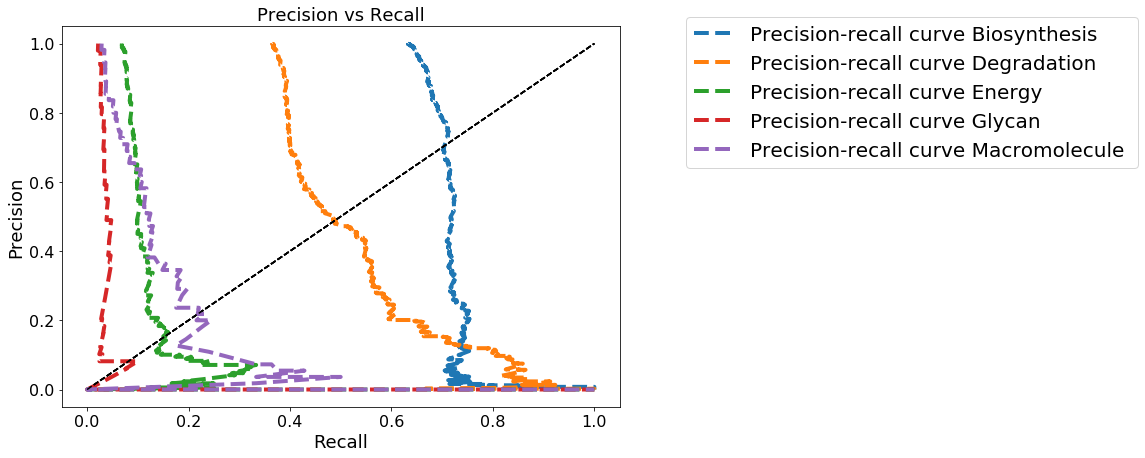

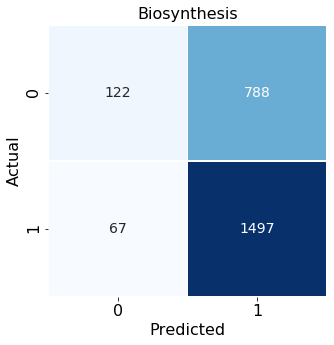

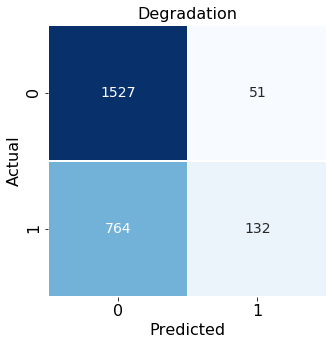

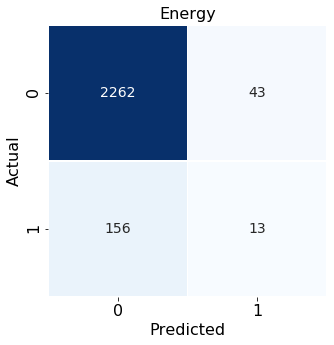

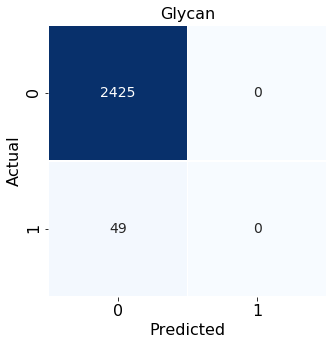

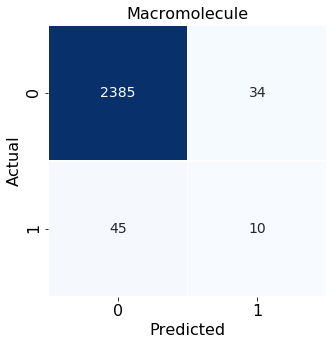

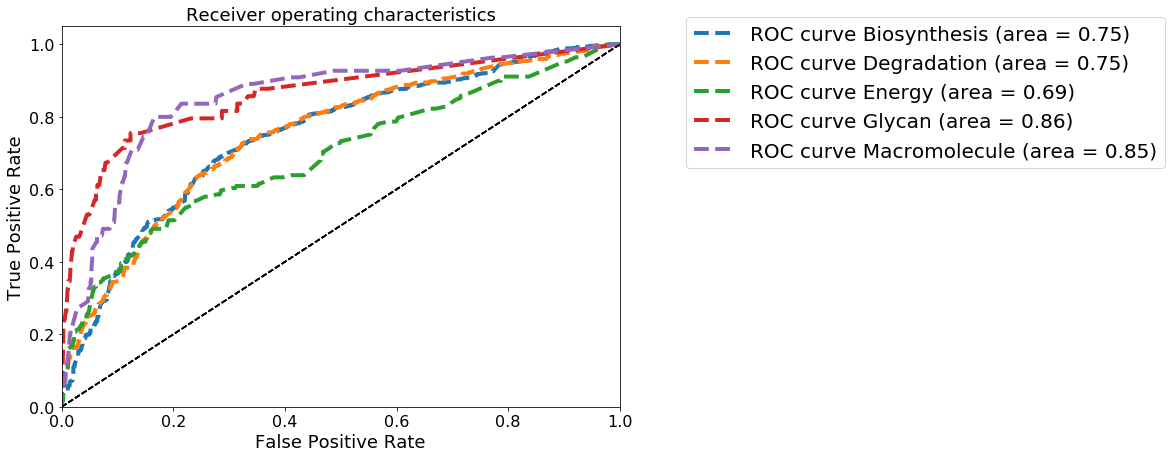

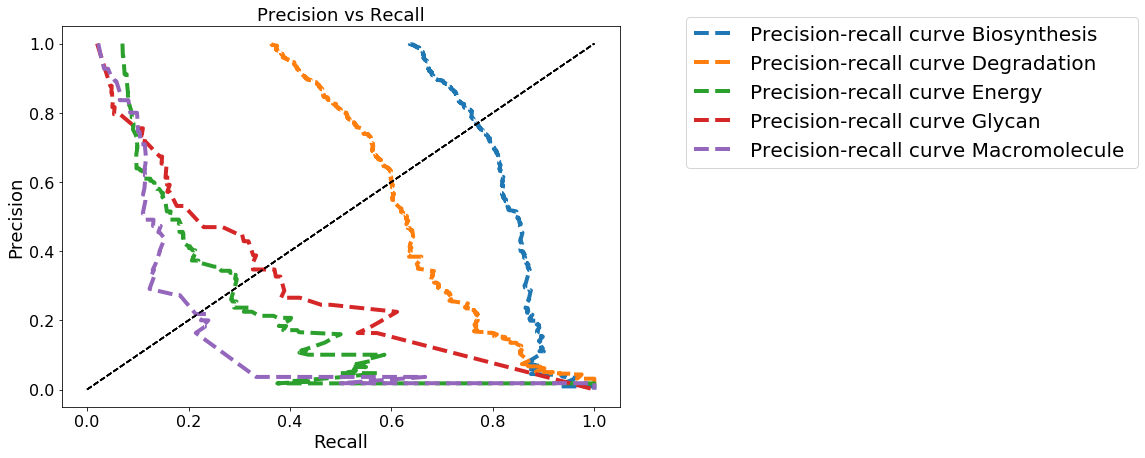

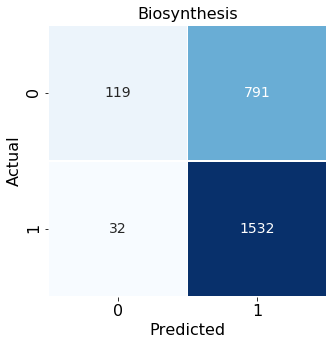

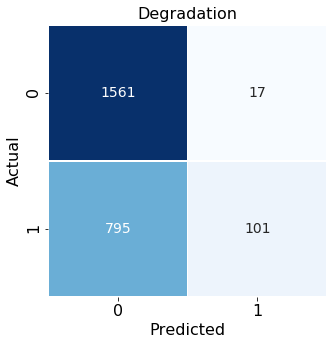

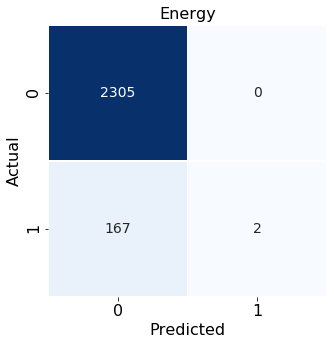

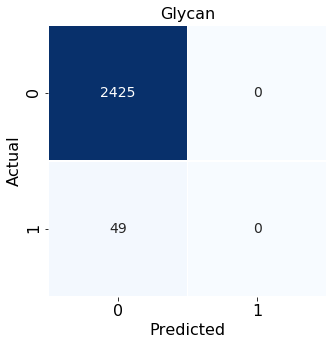

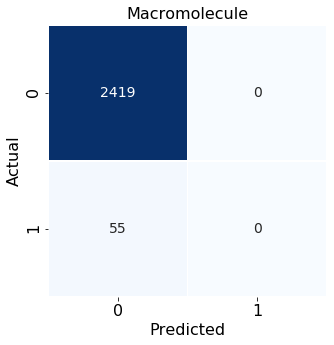

In [26]:
X_train,Y_train=get_X_and_Y_train(data_df_multi,categories)
X_test_c,Y_test_c=get_X_and_Y_annot2(data_df_multi,categories)
model_valid(X_train,Y_train,X_test_c,Y_test_c,categories)


### Validation: 1 letter annotation

(0.6018593371059013,) 0.16321746160064673 0.6228442468337375 0.6245957962813256 0.6438965238480194 0.08272702775532202
(0.5933710590137429,) 0.16806790622473727 0.6115939099973052 0.6115939099973052 0.6321746160064673 0.07060091619509568


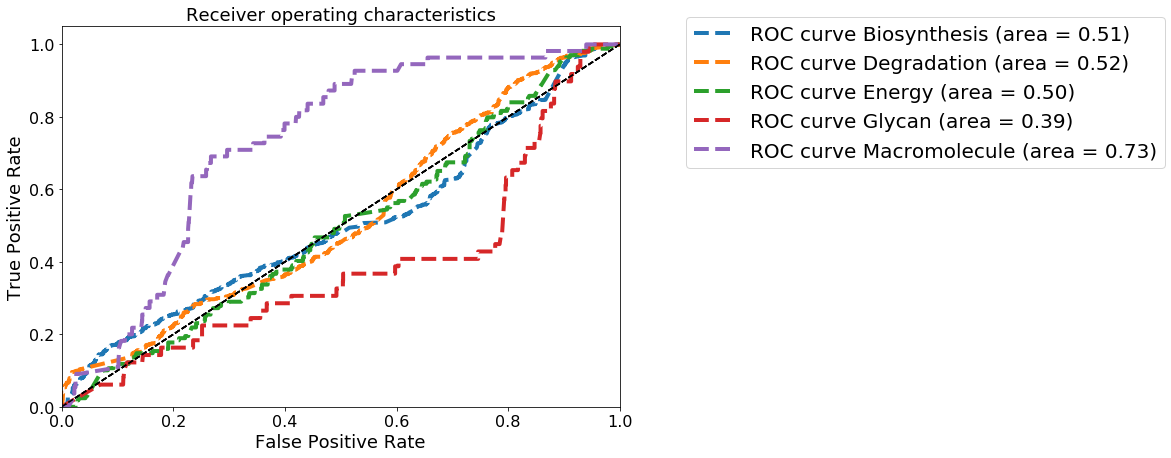

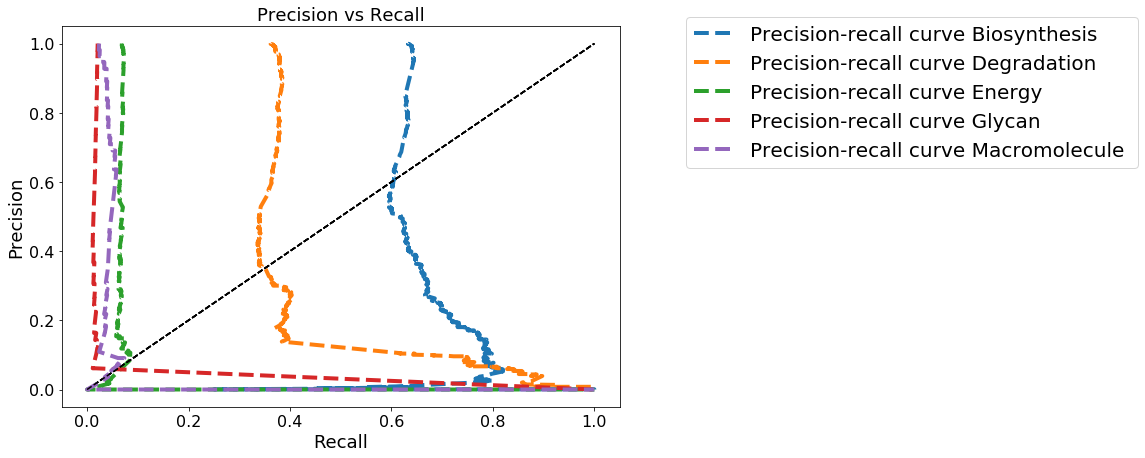

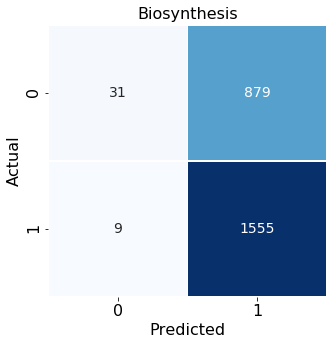

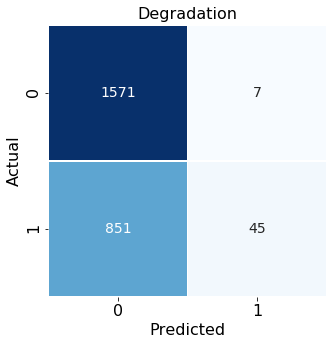

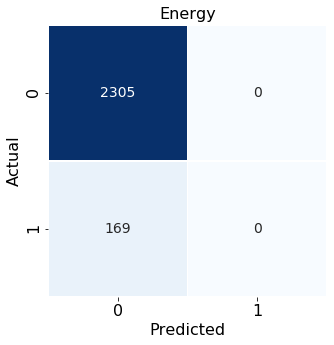

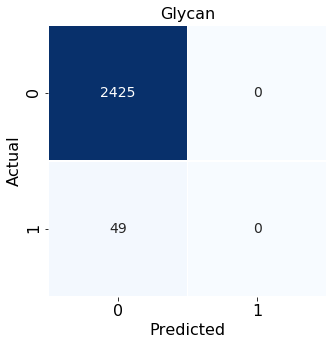

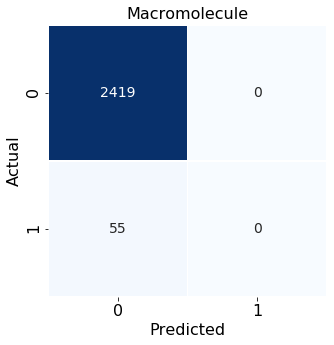

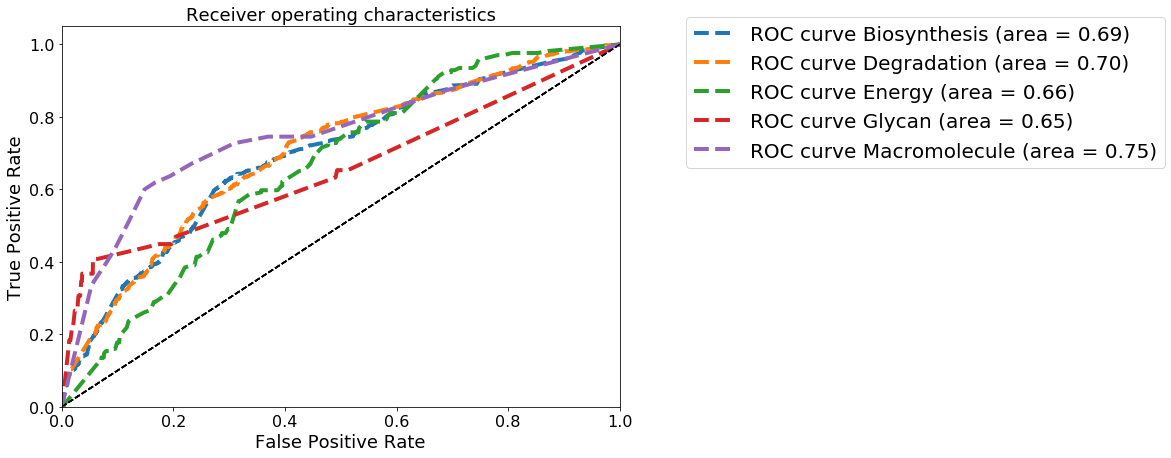

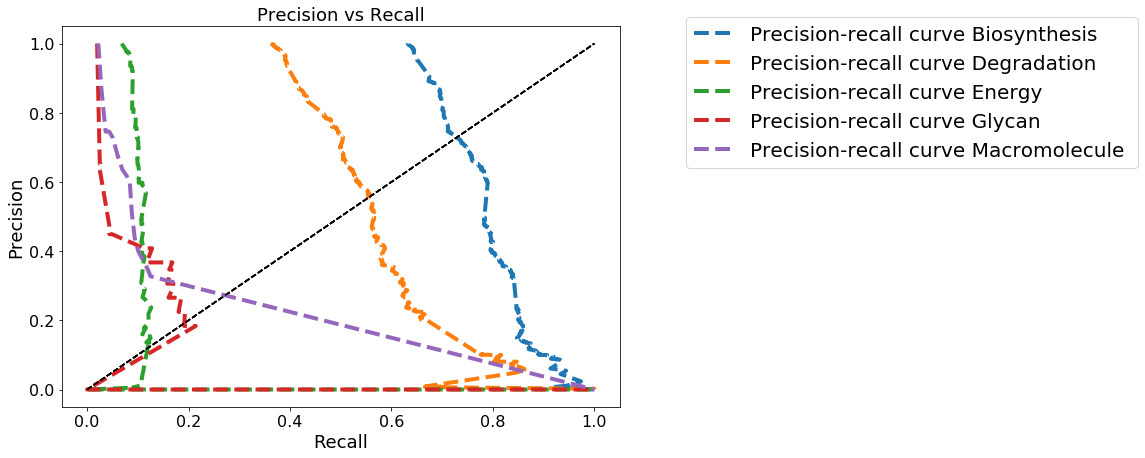

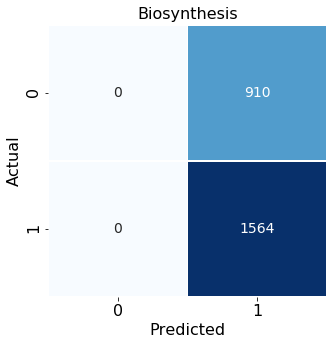

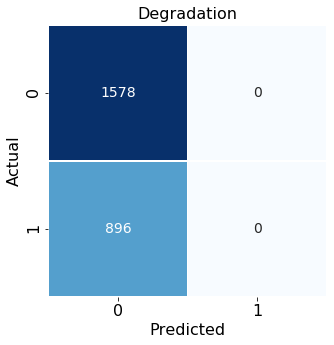

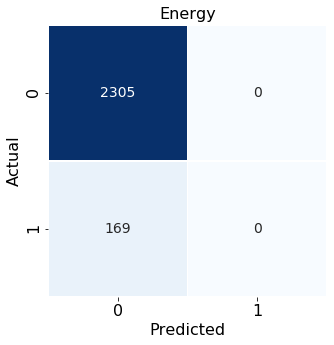

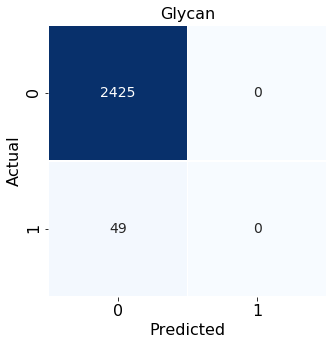

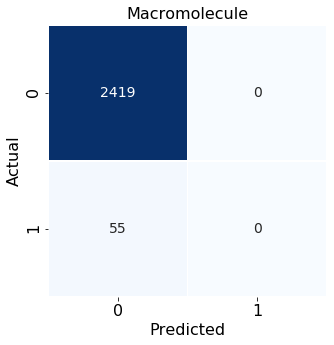

In [27]:
X_train,Y_train=get_X_and_Y_train(data_df_multi,categories)
X_test_c,Y_test_c=get_X_and_Y_annot1(data_df_multi,categories)
model_valid(X_train,Y_train,X_test_c,Y_test_c,categories)


### Validation: OHC

(0.7123623011015912,) 0.09914320685434516 0.7594859241126071 0.7737658098735211 0.7943696450428397 0.18727050183598531
(0.7001223990208079,) 0.11162790697674418 0.7383578431372549 0.7487745098039217 0.7685866013071895 0.15196078431372548


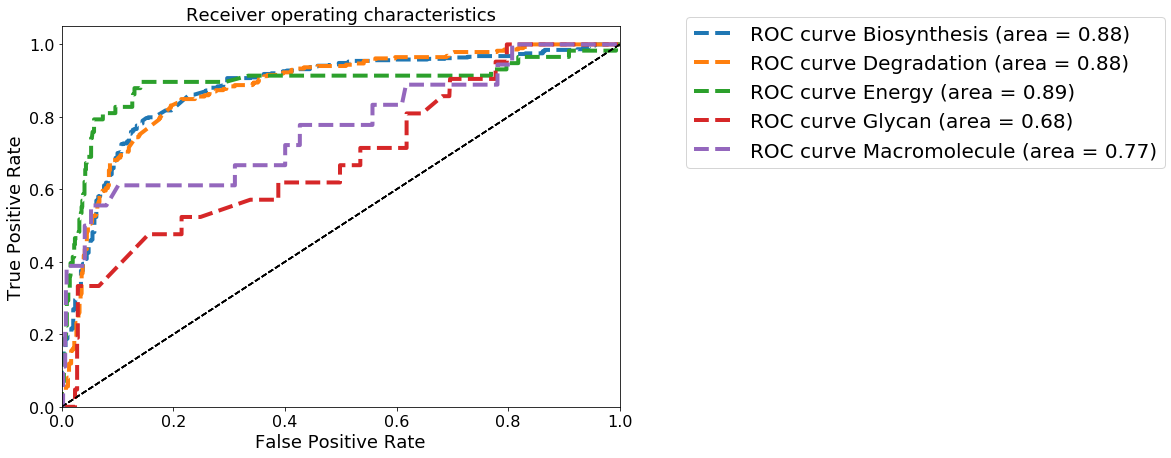

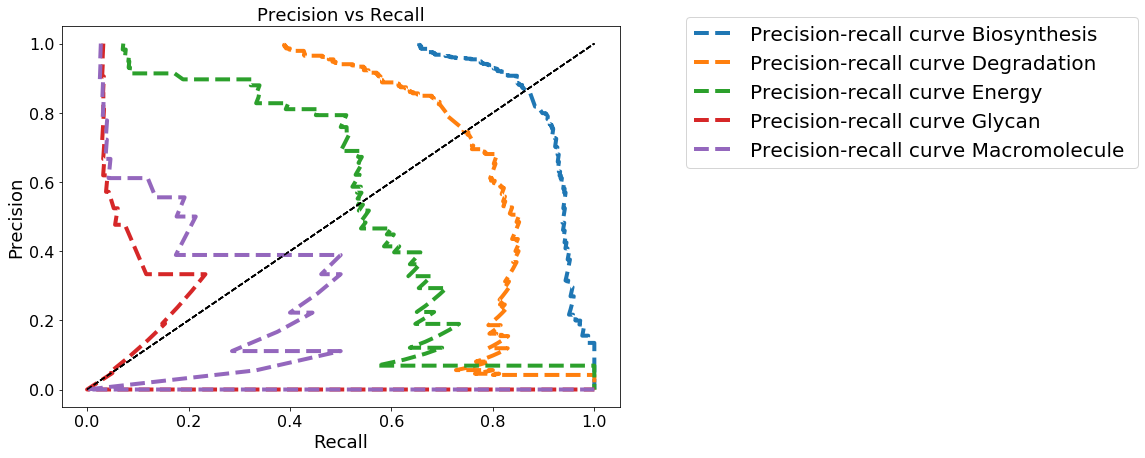

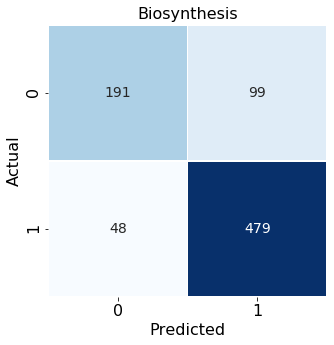

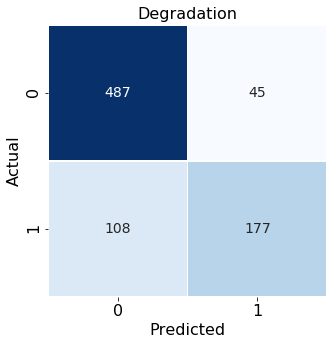

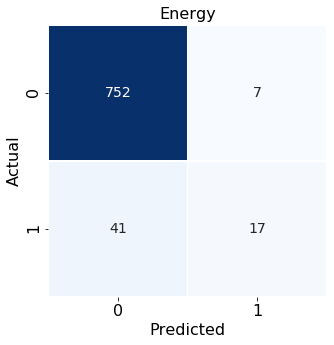

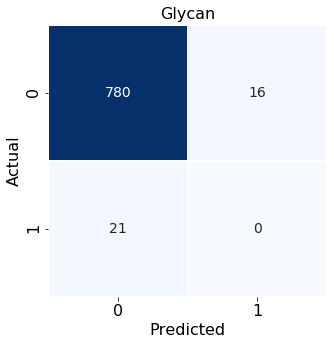

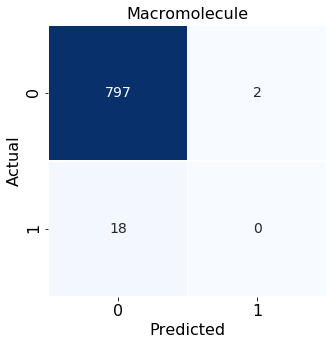

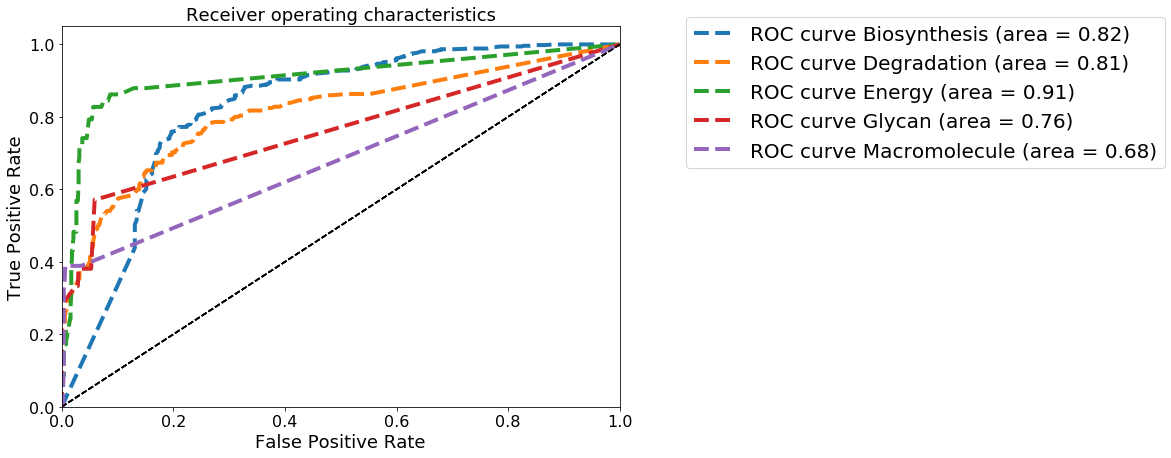

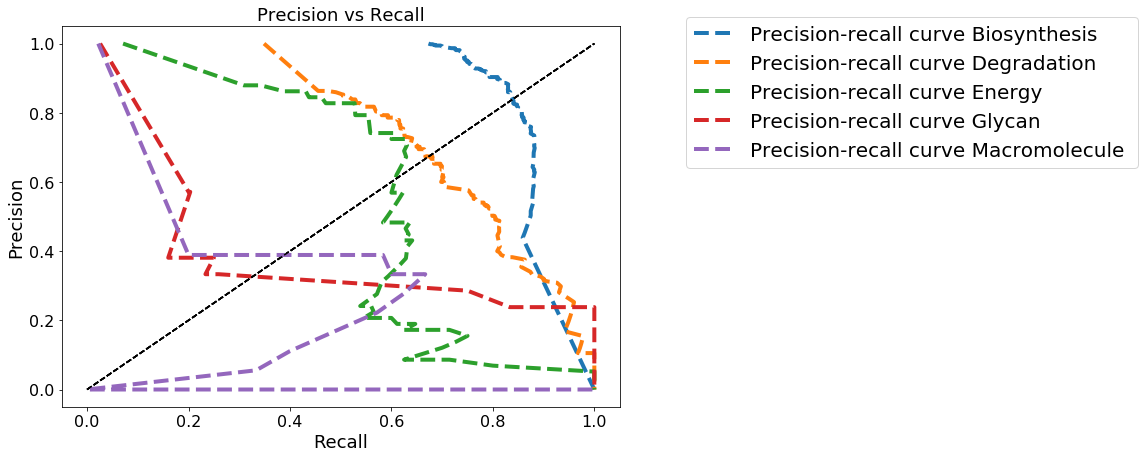

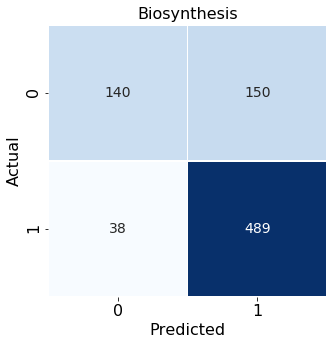

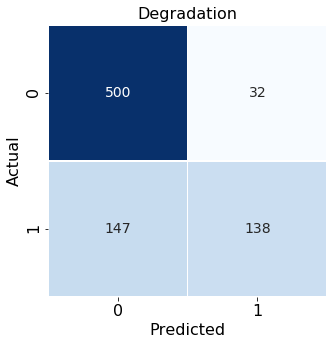

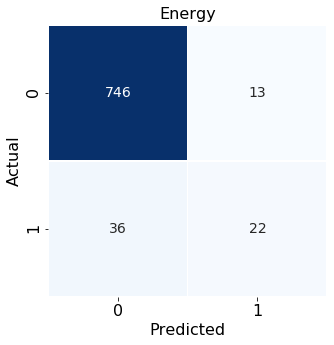

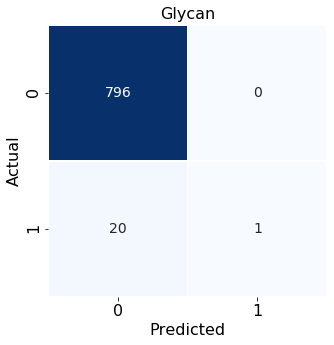

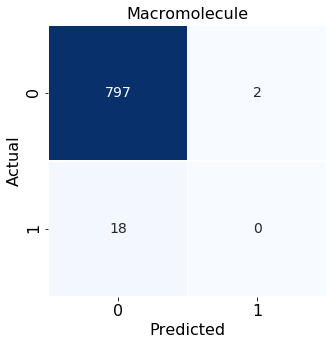

In [28]:
X_train,Y_train,X_test,Y_test=get_X_and_Y_control(data_df_multi,categories)
model_valid(X_train,Y_train,X_test,Y_test,categories)


In [ ]:
fname='df_all_map_pathways.pkl'
data_df=pickle.load(open(Path+fname,'rb'))
data_df.head()


In [ ]:
X_train,Y_train,X_test,Y_test=get_X_and_Y(data_df_multi,categories)
model_valid(X_train,Y_train,X_test,Y_test,categories)


In [ ]:
X_test[0]
        model=tup[1].fit(X_train, Y_train)
        prediction=model.predict(X_test)
        prediction_prob=model.predict_proba(X_test)
        Y_pred = model.predict(X_test)


In [ ]:
data_df_multi[data_df_multi['Map']=='PWY-5410']['EC_set'].to_list()